# Predicting Future Sales

This project is part of a Kaggle competition where participants are tasked to predict sales data for up to 6 weeks in advance for various convenience stores. The Kaggle competition description reads as follows:

"Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied."

For exploratory data analysis step, I used all the data provided by this particular data set from the Kaggle competition (there were a few other data sets provided). Due to time constraints, I only focused on using Sales data for building my actual model. Through exploratory analysis, I learn that the data is stationary (constant mean and variance), so I use exponential smoothing as my main analytical tool. 

**Note:** Please note that I did this project while starting my MS in Analytics program at Georgia Tech in August 2019. I think it is representative of the work I can do without much formal instruction. I'm confident that my work and analytical capabilities will improve as I complete the MS program. 

## The Data

- **Id**: an Id that represents a (Store, Date) duple within the test set
- **DayOfWeek**: Day of the week, 1 being Monday and 7 being Sunday
- **Date**: Date
- **Store**: a unique Id for each store
- **Sales**: the turnover for any given day (this is what you are predicting)
- **Customers**: the number of customers on a given day
- **Open**: an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday**: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday**: indicates if the (Store, Date) was affected by the closure of public schools
- **Promo**: indicates whether a store is running a promo on that day

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import linear_model
import plotly.plotly as py
import warnings
from pandas import Series
from matplotlib import pyplot
from datetime import datetime
from statsmodels.tsa.api import ExponentialSmoothing
import matplotlib.patches as mpatches
warnings.filterwarnings("ignore")



#We upload a file of homes listed for sale on April 10, 2019. 
#To gather this data, I used Scrapy to scrape the Encuentra24 listings-for-sale website
df = pd.read_csv('//Users/reynaldo/Documents/ROSSMANN DATA/train.csv')
print('Number of rows:', len(df))
df.head()

Number of rows: 1017209


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


We have a 1 million + row data set. I check for null values and see that we have no null values:

In [47]:
print (df.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


Now we check data types to see if we will have to do some casting:

In [48]:
df.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

StateHoliday column has three different possible values: a = public holiday, b = Easter holiday, c = Christmas, 0 = None. We cast DayOfWeek as datetime:

In [49]:
df.Date = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index(['Date'], drop = True, inplace = True)
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


## Exploratory Data Analysis

I create dummy variables out of StateHoliday column and rename them to make it easier for the exploratory analysis:

In [50]:
df = pd.get_dummies(df, drop_first= True)
df.rename(columns={'StateHoliday_0': 'NoStateHoliday', "StateHoliday_a": "PublicHoliday", "StateHoliday_b": "EasterHoliday", 'StateHoliday_c': 'Christmas'}, inplace = True)

In [51]:
print('Number of different stores in the data set:', len(df.groupby('Store')))

Number of different stores in the data set: 1115


We have a bit over two years worth of data, from January 2013 to July 2015:

In [52]:
print('The oldest date on the data set is:', df.index.min(), 'and the earliest date is', df.index.max(), 'which corresponds to', df.index.max()-df.index.min())

The oldest date on the data set is: 2013-01-01 00:00:00 and the earliest date is 2015-07-31 00:00:00 which corresponds to 941 days 00:00:00


Now plot the average daily sales among all stores:

Text(0, 0.5, 'Average Daily Sales Among All Stores US$')

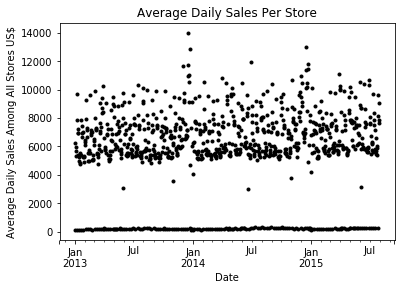

In [53]:
total_sales = Series(df.groupby('Date').Sales.mean())
total_sales.plot(style = 'k.', title = 'Average Daily Sales Per Store')
plt.ylabel('Average Daily Sales Among All Stores US$')

Our time series plot suggests that the data for daily store average sales is stationary (i.e. has roughly constant mean and variance), which suggests that we could do exponential smoothing on this data. 

Below, we see that average stores sales among all stores has a fairly wide distribution, with the standard deviation being about half of the mean value:

In [54]:
print('Average daily sales of all stores is:', round(np.mean(total_sales)))
print('Standard deviation of all stores is:', round(np.std(total_sales)))

Average daily sales of all stores is: 5783.0
Standard deviation of all stores is: 2887.0


Average sales per day are largest on Monday, and decrease until reaching the very lowest average sales on Sunday:

In [55]:
pd.DataFrame(df.groupby('DayOfWeek').Sales.mean()).set_index(pd.Index(['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])).rename(columns={"Sales": "AverageSales"})

,AverageSales
Mon,7809.044510
Tue,7005.244467
Wed,6555.884138
Thurs,6247.575913
Fri,6723.274305
Sat,5847.562599
Sun,204.183189


There are a bunch of dates with 0 sales, so I calculate the average number of days with zero sales for each store:

In [56]:
print('Average number of days without sales for all stores between January 2013 to July 2015:', round(df[df.Sales ==0].groupby('Store').count().DayOfWeek.mean(),2))
print('Standard deviation of mean number days without sales for all stores between January 2013 to July 2015:', round(np.std(df[df.Sales ==0].groupby('Store').count().DayOfWeek),2))

Average number of days without sales for all stores between January 2013 to July 2015: 156.44
Standard deviation of mean number days without sales for all stores between January 2013 to July 2015: 20.17


Now I check the distribution of days without sales (store was closed), average daily sales per store, and average number of daily customers per store:

Text(0.5, 0, 'Average Daily Customers')

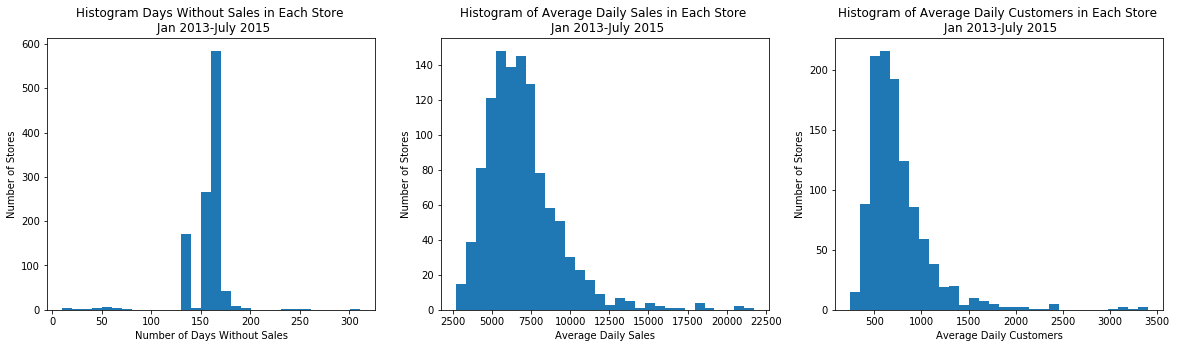

In [57]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(hspace=0.5)
ax1 = fig.add_subplot(131)
ax1.hist(df[df.Sales ==0].groupby('Store').count().DayOfWeek, bins=30)
ax1.set_title('Histogram Days Without Sales in Each Store \n Jan 2013-July 2015')
ax1.set_ylabel('Number of Stores')
ax1.set_xlabel('Number of Days Without Sales')

ax2 = fig.add_subplot(132)
ax2.hist(df[df.Sales!=0].groupby('Store').mean().Sales, bins=30)
ax2.set_title('Histogram of Average Daily Sales in Each Store \n Jan 2013-July 2015')
ax2.set_ylabel('Number of Stores')
ax2.set_xlabel('Average Daily Sales')

ax3 = fig.add_subplot(133)
ax3.hist(df[df.Sales!=0].groupby('Store').mean().Customers, bins=30)
ax3.set_title('Histogram of Average Daily Customers in Each Store \n Jan 2013-July 2015')
ax3.set_ylabel('Number of Stores')
ax3.set_xlabel('Average Daily Customers')

Evidently, number of days without sales (i.e. store is closed) has very little variation among all stores, with most stores closing for around 130-180 days in the whole period. Average number of daily customers has a similar, right skewed distribution as average daily sales. As seen below these two variables are positively correlated. It is interesting that there seems to be a floor on the minimum sales amount corresponding to each number of customers, which seems to correspond to the fact that all customers make some minimum purchase amount (perhaps corresponding to the lowest cost item in the store):

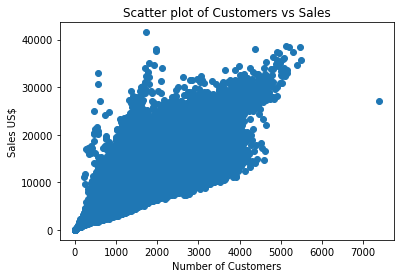

In [58]:
plt.scatter(df.Customers, df.Sales)
plt.title('Scatter plot of Customers vs Sales')
plt.xlabel('Number of Customers')
plt.ylabel('Sales US$')
plt.show()

We see that there are a large number of school holidays that affected at least one store (478 days out of roughly 900 days in the data set). This is unlike StateHolidays, which happen much less frequent than school holidays:

In [59]:
print('Number of school holidays that affected at least one store:', len(df[df.groupby('Date').SchoolHoliday.sum()!=0].groupby('Date').SchoolHoliday.sum()))

Number of school holidays that affected at least one store: 478


Now I check the number of stores that closed in each holiday season:

In [60]:
d = {'PublicHoliday': df[df.groupby('Date').PublicHoliday.sum()!=0].groupby('Date').PublicHoliday.sum(), 
     'EasterHoliday': df[df.groupby('Date').EasterHoliday.sum()!=0].groupby('Date').EasterHoliday.sum(),
    'Christmas': df[df.groupby('Date').Christmas.sum()!=0].groupby('Date').Christmas.sum()}

closed_stores = pd.DataFrame(data=d)
closed_stores.fillna(0)

,PublicHoliday,EasterHoliday,Christmas
Date,,,
2013-01-01,1114.0,0.0,0.0
2013-01-06,309.0,0.0,0.0
2013-03-29,0.0,1115.0,0.0
2013-04-01,0.0,1115.0,0.0
2013-05-01,1115.0,0.0,0.0
2013-05-09,1115.0,0.0,0.0
2013-05-20,1115.0,0.0,0.0
2013-05-30,766.0,0.0,0.0
2013-08-15,180.0,0.0,0.0


In about half of PublicHolidays all stores are closed. There seems to be a trend for fewer stores closing on Public Holidays for recent years. If a store closes for the 25th, then it seems that it also closes on the 26th. For EasterHoliday, all stores closed on the same days (during March or April). 

For the testing set period (August- September 2015), we see that there are usually no State holidays. Only 2013 had a Public Holiday in August 15 in which 180 stores closed, but this holiday did not occur ein 2014. This suggests that it is not imperative to predict stores closures for our testing time period, so I will choose to not predict State holidays to keep my analysis simple. 

It is also interesting to note that in the first PublicHoliday, there is one store that did not close. I check whether there is missing data for stores:

In [61]:
from statistics import mean 

open_days = [0] *len(df.groupby('Store'))
missing_days = 0
sum_missing = 0
for i in range(len(df.groupby('Store'))):
    open_days[i] = len(df[df.Store == i].Sales)
    if len(df[df.Store == i].Sales)!=942:
        sum_missing += (942-len(df[df.Store == i].Sales))
        missing_days +=1

print('Average number of days we have data for each store:', round(mean(open_days)))
print('Number of stores with missing values:', missing_days)
print('Average number of missing days for stores with missing data:', round(sum_missing/missing_days))

Average number of days we have data for each store: 911
Number of stores with missing values: 182
Average number of missing days for stores with missing data: 187


Indeed, there are 182 stores with missing sales data (each missing an average of 187 data points). On average, each store has 911 sales data points out of 942 total days in the training set. 

Below we can see that average store sales (for those that remain open) is higher during holidays, specially state holidays, which makes me wonder why a store would close during holiday seasons:

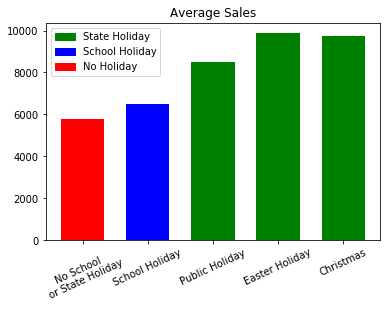

In [62]:
y = [df[(df.SchoolHoliday ==0) & (df.NoStateHoliday ==1)].Sales.mean(), df[(df.SchoolHoliday==1)].Sales.mean(), df[(df.PublicHoliday!=0) & (df.Sales !=0)].Sales.mean(), df[(df.EasterHoliday!=0) & (df.Sales !=0)].Sales.mean(), df[(df.Christmas !=0) & (df.Sales !=0)].Sales.mean()]
N = len(y)
x = ['No School \n or State Holiday', 'School Holiday', 'Public Holiday', 'Easter Holiday', 'Christmas']
width = 1/1.5
plt.xticks(range(len(x)), x, rotation = 25)
plt.title('Average Sales')
plt.bar(x, y, width, color=['r', 'b', 'g', 'g', 'g'])
green_patch = mpatches.Patch(color='green', label='State Holiday')
blue_patch = mpatches.Patch(color='blue', label='School Holiday')
red_patch = mpatches.Patch(color='red', label='No Holiday')
plt.legend(handles=[green_patch, blue_patch, red_patch])
plt.show()

## Fill in Missing Values

As noted above, there are 182 stores (out of 1115) with missing sales data, each with an average of 187 missing days. We have 182*187 = 34,034 missing data points, which is about 3% of all our data, so we can do imputing without issues. Given that State Holidays don't usually happen in the test set time period (August-September), and due to time constraints at the time I made this project, I will only use Sales column data to create my model. 

First I pivot my table to have Store number as column and Sales as values: 

In [63]:
df1 = df.pivot(columns='Store', values=['Sales'])
df1.columns = np.arange(1,1116)

I will fill in missing values with each store's average sales value for the whole training set period. I acknowledge that there has to be a better way to fill in missing values, such as perhaps doing exponential smoothing to fill in the missing values themselves, or perhaps adding random noise to the imputed values. Because of time restrictions, I will stick with this simpler method. 

In [64]:
df1.fillna(df1.mean(), inplace = True)

This is what the final data frame looks like: 

In [65]:
df1.head()

,1,2,3,4,5,6,7,8,9,10,...,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,5530.0,4422.0,6823.0,9941.0,4253.0,6089.0,8244.0,5419.0,4903.0,4812.0,...,5099.0,3955.0,6220.0,4576.0,4126.0,5097.0,10797.0,6218.0,20642.0,3697.0
2013-01-03,4327.0,4159.0,5902.0,8247.0,3465.0,5398.0,7231.0,4842.0,4602.0,4675.0,...,4330.0,3151.0,4779.0,3654.0,3508.0,4579.0,8716.0,5563.0,18463.0,4297.0
2013-01-04,4486.0,4484.0,6069.0,8290.0,4456.0,6092.0,7758.0,4059.0,4798.0,5114.0,...,3956.0,3990.0,5491.0,3596.0,3933.0,4640.0,9788.0,5524.0,18371.0,4540.0
2013-01-05,4997.0,2342.0,4523.0,10338.0,1590.0,3872.0,5218.0,2337.0,4254.0,4256.0,...,2624.0,5128.0,2113.0,2897.0,3156.0,3325.0,9513.0,5194.0,18856.0,4771.0


## Modeling Details

The competition evaluates participants based on Root Mean Squared Percentage Error, defined as: 

$$\sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(\frac{y_{i}-\hat{y_{i}}}{y_{i}}\right)^2}$$

where yhat_i denotes sales predictions for date i and y_i denotes actual sales on day i. Any day and stores with 0 sales is ignored in scoring, so we can assume there won't be any 0 true sales values. 

As state above, my analysis will use only training set sales data to predict sales for the August 2015-September 2015 period. I will use exponential smoothing on the average of all stores' daily sales data to predict the test dates sales values. This is due mainly to time restrictions. As noted in my exploratory analysis, the data seems stationary, so exponential smoothing seems like a reasonable choice.

I also need to separate my data into training and validation sets to choose the best parameters for the exponential smoothing model. Since we have to estimate sales up to 6 weeks in the future in the Kaggle competition, and since we have time series data, I choose to validate my models on the last 6 weeks of the training set, and train the model on the remaining days.

## Exponential Smoothing Hyperparameter Search

I will separate my data set into a training set and validation set, using the last 48 days as validation data (the same number of days as in the test set) and the rest as training data. As previously noted, since my data set is too big, I will only train and validate on the mean of all stores, rather than on each individual store. 

In [66]:
mean_data = df1.copy()
mean_data['Mean_Sales'] = mean_data.mean(numeric_only=True, axis=1)
mean_data = pd.DataFrame(mean_data.iloc[:, -1]).copy()

train = mean_data.iloc[:len(df1)-48,:].copy()
validate = mean_data.iloc[len(df1)-48:,:].copy()

Recall the exponential smoothing additive model equations:

$$\hat{y}_{t+h|t} = l_{t} +hb_{t} + s_{t+h-m(k+1)}$$
$$l_{t} = \alpha(y_{t}-s_{t-m})+ (1-\alpha)(l_{t-1} + b_{t-1})$$
$$b_{t} = \beta(l_{t}- l_{t-1}) + (1+\beta)b_{t-1}$$
$$s_{t} = \gamma(y_{t}- l_{t-1}- b_{t-1})+ (1-\gamma)s_{t-m}$$

Validation step doing Grid Search:
- I try out different alpa values from 0 to 1, at 0.1 intervals
- I try additive for both seasonal and trend, and also put in None to create a model without a seasonal or trend component
- I try seasonal periods of one week, a quarter, a semester, and annual, as these are good candidates for sales seasonality. 

In [67]:
#We will try validating using these hyperparamters to try and find the optimum:
smoothing_level = [None, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
seasonal = [None, 'additive', 'mult']
trends= [None, 'additive']
seasonal_periods = [7, 90, 180, 365]

start = datetime.strptime('2015-06-14', '%Y-%m-%d')
end = datetime.strptime('2015-07-31', '%Y-%m-%d')

min_error = 99999999999
best_alpha = None
best_trend = None
best_period = None
best_seasonal = None

for alpha in smoothing_level:
    for period in seasonal_periods:
        for t in trends:
            for season in seasonal:
                #Fit exponential smoothing model to Store i
                exp = ExponentialSmoothing(train, seasonal= season, seasonal_periods = period, trend = t) 
                exp_model = exp.fit(smoothing_level=alpha) 
                #Predict Sales data for testing set period from August 01, 2015 to September 17, 2015
                pred = exp_model.predict(start= start, end=end)
                pred = pd.DataFrame(pred, columns = ['Predicted_Sales'])
                
                #Evaluate the root mean squared percentage error:
                error = np.sqrt(1/len(validate)*sum(((validate['Mean_Sales']-pred['Predicted_Sales'])/validate['Mean_Sales'])**2))
                if error<min_error:
                    min_error = error
                    best_alpha = alpha
                    best_trend = t
                    best_period = period
                    best_seasonal = season

The best hyperparameters found where:

In [68]:
print('The best ERROR: {}, smoothing_level: {}, seasonal_period: {}, seasonal: {}, trend: {}'.format(min_error, best_alpha, best_period, best_seasonal, best_trend))

The best ERROR: 0.1658953363207862, smoothing_level: 0.9, seasonal_period: 7, seasonal: additive, trend: None


The optimal hyperaparamters found were: 
- alpha = 0.9, meaning that our model puts more emphasis on recent data points rather than on past data points to make predictions
- seasonality = additive, meaning that incorporating additive seasonality to our model outperforms having no seasonality at all
- seasonal_period = 7, meaning that our model found more predictive accuracy with weekly seasonality
- trend = None, meaning that having no trend outperforms the predictive accuracy of having an additive trend component

## Exponential Smoothing Predicting Test Data Set

Now I use the hyperparameters found above to  make predictions in our test set. I get the testing set on which I need to predict sales values:

In [69]:
#Since I am only using Store# and Date as predictors, I only get these columns from the test set
test = pd.read_csv('//Users/reynaldo/Documents/ROSSMANN DATA/test.csv')[['Id', 'Date']]

#test[test.Store ==1]
test.head()

,Id,Date
0,1,2015-09-17
1,2,2015-09-17
2,3,2015-09-17
3,4,2015-09-17
4,5,2015-09-17


Now I use the optimum hyperparameters found above to predict dates found in the test set:

In [70]:
start = datetime.strptime('2015-08-01', '%Y-%m-%d')
end = datetime.strptime('2015-09-17', '%Y-%m-%d')

#Fit exponential smoothing model to Store i
exp = ExponentialSmoothing(mean_data, seasonal= best_seasonal, seasonal_periods = best_period, trend = best_trend) 
exp_model = exp.fit(smoothing_level=best_alpha) 

#Predict Sales data for testing set period from August 01, 2015 to September 17, 2015
pred = exp_model.predict(start= start, end=end)
pred = pd.DataFrame(pred, columns = ['Predicted_Sales'])
pred

pred_df = pred.reset_index(level=0)
pred_df.columns = ['Date', 'Sales']

#Cast datetime as string in order to do proper joins
predictions = pred_df.copy()
predictions.Date = predictions.Date.apply(lambda x: x.strftime('%Y-%m-%d'))
predictions = test.merge(predictions, on =['Date'], how = 'outer').copy()
predictions = predictions[['Id', 'Sales']].copy()
predictions.head()

,Id,Sales
0,1,8517.454022
1,2,8517.454022
2,3,8517.454022
3,4,8517.454022
4,5,8517.454022


We only get 7 unique predictions that repeat on a weekly basis:

In [71]:
days = pd.DataFrame({'Day': ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'Prediction': pred.Predicted_Sales.unique()})
days

,Day,Prediction
0,Saturday,8146.024964
1,Sunday,2642.365089
2,Monday,9739.110385
3,Tuesday,8894.122734
4,Wednesday,8461.448092
5,Thursday,8517.454022
6,Friday,8995.337562


We see that Sunday is the lowest predicted sales day we have. The other days have similar sales predictons, with Monday being the highest of all:

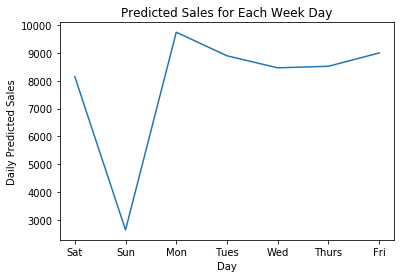

In [72]:
plt.plot(['Sat', 'Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri'], days.Prediction)
plt.ylabel('Daily Predicted Sales')
plt.xlabel('Day')
plt.title('Predicted Sales for Each Week Day')
plt.show()

Now I write the results onto a file to submit it to Kaggle:

In [73]:
predictions.to_csv('/Users/reynaldo/Documents/ROSSMANN DATA/submission.csv', index=False)

## Results and Conclusion

My Kaggle submission got an error of 0.71373, which is much higher than the error I got in the validation data set of 0.165. This could mean that I should have done a more robust validation in order to get a more accurate error rate for my model (perhaps using multiple validation sets). Also, a more robust imputation method for missing values should lead to more accurate results, perhahps by using other predictors to fill in missing sales data.

Another weak aspect of my model is that I averaged sales among all stores for training and predictions. This eliminates the ability of my model to make more accurate predictions based on stores number. Note that I chose to use average sales among all stores because of time constraints: training and predicting sales for each store was extremely time consuming, taking about 1 hour to train a single model. More time (or more computing power) would've allowed me to build a more accurate model, allowing me to also try other time series models such as ARIMA and moving average.

Finally, my error rate could've been so high because of the fact that I didn't include any other predictors in my data besides Sales (due to time constraints). The lack of predictors and the high error rate suggest that my model may not be outperforming store managers' predictive sales capacities. A more robust model building is required to meet this goal. 

This was a challenging data set to work with because of its size (1 million+ data points). I actually tried to create an exponential smoothing model for each of the stores, but stopped due to time constraints (one model would take about an hour to train, so doing hyperparameter optimization via grid search was infeasable). I am confident that as I progress through my MS in Analytics program, I will broaden my tools set and model building capabilities to create more accurate models.